In [6]:
from google.colab import drive
drive.mount("/content/d")

Drive already mounted at /content/d; to attempt to forcibly remount, call drive.mount("/content/d", force_remount=True).


In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git d/MyDrive/zoomcamps_ml/08_deep_learning/data

Cloning into 'd/MyDrive/zoomcamps_ml/08_deep_learning/data'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (3783/3783), done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [9]:
path = "d/MyDrive/zoomcamps_ml/08_deep_learning/data/train/t-shirt/"
name = "00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg"
x = load_img(path+name, target_size=(299,299))
x = np.array(x)

In [11]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds=train_gen.flow_from_directory(
    "d/MyDrive/zoomcamps_ml/08_deep_learning/data/train/",
    target_size=(150,150),
    batch_size=32
)

x,y = next(train_ds)
x.shape()

Found 3068 images belonging to 10 classes.


(32, 150, 150, 3)

In [12]:
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_ds=train_gen.flow_from_directory(
    "d/MyDrive/zoomcamps_ml/08_deep_learning/data/validation",
    target_size=(150,150),
    batch_size=32,
    shuffle=False,
)

Found 341 images belonging to 10 classes.


In [13]:
base_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(150,150,3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150,150,3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

preds = model.predict(x)
preds.shape

1/1 [==============================] - 10s 10s/step


(32, 10)

In [14]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
   optimizer=optimizer,
   loss=loss,
   metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=3,
    validation_data=valid_ds
)

Epoch 1/3
96/96 [==============================] - 23s 170ms/step - loss: 1.2350 - accuracy: 0.6636 - val_loss: 1.0370 - val_accuracy: 0.7449
Epoch 2/3
96/96 [==============================] - 18s 186ms/step - loss: 0.5476 - accuracy: 0.8338 - val_loss: 0.7948 - val_accuracy: 0.7859
Epoch 3/3
96/96 [==============================] - 13s 139ms/step - loss: 0.3487 - accuracy: 0.8778 - val_loss: 1.1330 - val_accuracy: 0.7683


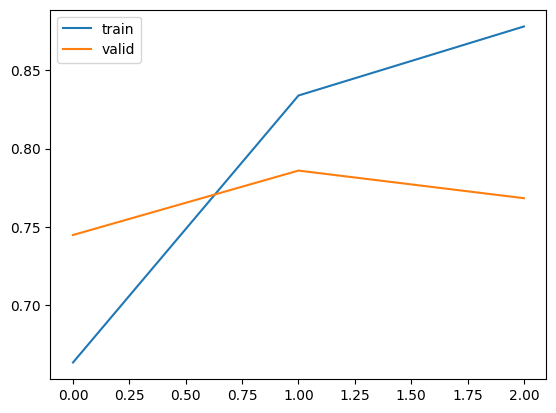

In [15]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="valid")
plt.legend();

In [16]:
def make_model(learning_rate = 0.01):
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(150,150,3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
    )

    return model

In [17]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(
        train_ds,
        epochs=3,
        validation_data=valid_ds
    )
    scores[lr] = history.history['val_accuracy']
    print()

0.0001
Epoch 1/3
96/96 [==============================] - 19s 156ms/step - loss: 1.8637 - accuracy: 0.3726 - val_loss: 1.5315 - val_accuracy: 0.5044
Epoch 2/3
96/96 [==============================] - 15s 155ms/step - loss: 1.3498 - accuracy: 0.5655 - val_loss: 1.2104 - val_accuracy: 0.6129
Epoch 3/3
96/96 [==============================] - 14s 149ms/step - loss: 1.1211 - accuracy: 0.6447 - val_loss: 1.0432 - val_accuracy: 0.6804

0.001
Epoch 1/3
96/96 [==============================] - 17s 150ms/step - loss: 1.0951 - accuracy: 0.6333 - val_loss: 0.7286 - val_accuracy: 0.7801
Epoch 2/3
96/96 [==============================] - 19s 193ms/step - loss: 0.6326 - accuracy: 0.7813 - val_loss: 0.6298 - val_accuracy: 0.7977
Epoch 3/3
96/96 [==============================] - 15s 155ms/step - loss: 0.5065 - accuracy: 0.8360 - val_loss: 0.5817 - val_accuracy: 0.8123

0.01
Epoch 1/3
96/96 [==============================] - 17s 149ms/step - loss: 1.2385 - accuracy: 0.6721 - val_loss: 0.8473 - val_acc

In [20]:
# model.save_weights("model_v1.h5", save_format="h5")
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

learning_rate = 0.001

model = make_model(learning_rate=learning_rate)
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.0807 - accuracy: 0.6304

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 18s 160ms/step - loss: 1.0807 - accuracy: 0.6304 - val_loss: 0.7040 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 13s 134ms/step - loss: 0.6239 - accuracy: 0.7888 - val_loss: 0.6240 - val_accuracy: 0.8065
Epoch 3/10
96/96 [==============================] - 13s 136ms/step - loss: 0.5056 - accuracy: 0.8299 - val_loss: 0.5878 - val_accuracy: 0.7977
Epoch 4/10
96/96 [==============================] - 16s 162ms/step - loss: 0.4278 - accuracy: 0.8641 - val_loss: 0.5661 - val_accuracy: 0.8123
Epoch 5/10
96/96 [==============================] - 14s 141ms/step - loss: 0.3688 - accuracy: 0.8862 - val_loss: 0.5433 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 13s 137ms/step - loss: 0.3220 - accuracy: 0.9104 - val_loss: 0.5367 - val_accuracy: 0.8270
Epoch 7/10
96/96 [==============================] - 13s 134ms/step - loss: 0.2891 - accuracy: 0.9221 - val_loss: 0.5487 - val_accuracy: 0.8006
Epoch 8/10

In [23]:
def make_model(learning_rate = 0.01, size_inner=100):
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(150,150,3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
    )

    return model

In [24]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(
        train_ds,
        epochs=3,
        validation_data=valid_ds
    )
    scores[size] = history.history#['val_accuracy']
    print()

10
Epoch 1/3
96/96 [==============================] - 18s 141ms/step - loss: 1.4037 - accuracy: 0.5427 - val_loss: 0.9841 - val_accuracy: 0.6745
Epoch 2/3
96/96 [==============================] - 12s 129ms/step - loss: 0.8227 - accuracy: 0.7168 - val_loss: 0.7262 - val_accuracy: 0.7654
Epoch 3/3
96/96 [==============================] - 13s 136ms/step - loss: 0.6171 - accuracy: 0.7947 - val_loss: 0.6589 - val_accuracy: 0.7889

100
Epoch 1/3
96/96 [==============================] - 20s 140ms/step - loss: 0.9854 - accuracy: 0.6682 - val_loss: 0.6372 - val_accuracy: 0.7801
Epoch 2/3
96/96 [==============================] - 13s 139ms/step - loss: 0.5179 - accuracy: 0.8246 - val_loss: 0.5673 - val_accuracy: 0.8123
Epoch 3/3
96/96 [==============================] - 13s 138ms/step - loss: 0.3525 - accuracy: 0.8830 - val_loss: 0.5733 - val_accuracy: 0.7889

1000
Epoch 1/3
96/96 [==============================] - 17s 146ms/step - loss: 0.9188 - accuracy: 0.6900 - val_loss: 0.6371 - val_accuracy:

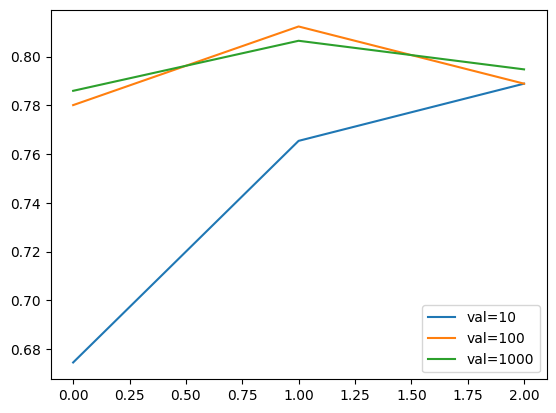

In [25]:
for size, hist in scores.items():
    plt.plot(hist["val_accuracy"], label=("val=%s"%size))
plt.legend();

In [26]:
def make_model(learning_rate = 0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(150,150,3)
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
    )

    return model

In [28]:
learning_rate = 0.001
size_inner = 100
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size_inner,
        droprate=droprate
    )
    history = model.fit(
        train_ds,
        epochs=3,
        validation_data=valid_ds
    )
    scores[droprate] = history.history#['val_accuracy']
    print()

1000
Epoch 1/3
96/96 [==============================] - 20s 159ms/step - loss: 0.9381 - accuracy: 0.6829 - val_loss: 0.6134 - val_accuracy: 0.7947
Epoch 2/3
96/96 [==============================] - 13s 134ms/step - loss: 0.5002 - accuracy: 0.8292 - val_loss: 0.6061 - val_accuracy: 0.8035
Epoch 3/3
96/96 [==============================] - 13s 139ms/step - loss: 0.3499 - accuracy: 0.8875 - val_loss: 0.5915 - val_accuracy: 0.8152

1000
Epoch 1/3
96/96 [==============================] - 21s 157ms/step - loss: 1.0781 - accuracy: 0.6392 - val_loss: 0.6990 - val_accuracy: 0.7947
Epoch 2/3
96/96 [==============================] - 14s 145ms/step - loss: 0.6119 - accuracy: 0.7852 - val_loss: 0.6101 - val_accuracy: 0.7977
Epoch 3/3
96/96 [==============================] - 13s 138ms/step - loss: 0.4568 - accuracy: 0.8435 - val_loss: 0.5746 - val_accuracy: 0.7918

1000
Epoch 1/3
96/96 [==============================] - 20s 174ms/step - loss: 1.2724 - accuracy: 0.5772 - val_loss: 0.7511 - val_accura

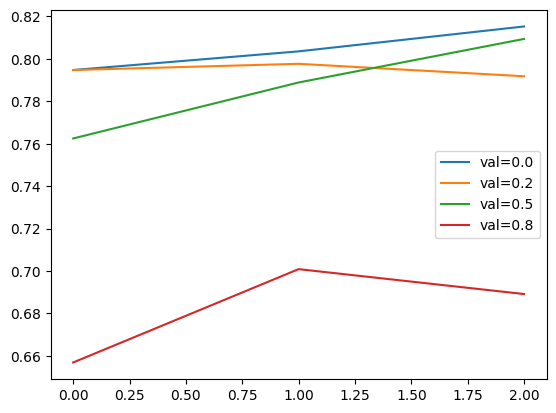

In [29]:
for droprate, hist in scores.items():
    plt.plot(hist["val_accuracy"], label=("val=%s"%droprate))
plt.legend();

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               rotation_range=30,
                               width_shift_range=10.0,
                               height_shift_range=10.0,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True)

train_ds = train_gen.flow_from_directory(
    "d/MyDrive/zoomcamps_ml/08_deep_learning/data/train",
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    "d/MyDrive/zoomcamps_ml/08_deep_learning/data/validation",
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "d/MyDrive/zoomcamps_ml/08_deep_learning/data/test",
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

model = keras.models.load_model('xception_v4_1_13_0.903.h5')
model.evaluate(test_ds)

In [ ]:
path = "d/MyDrive/zoomcamps_ml/08_deep_learning/data/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(299, 299))
x = np.array(img)
x = np.array([x])
x = preprocess_input(x)
pred = model.predict(x)

classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

dict(zip(classes, pred[0]))